In [1]:

!pip install monai


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 990 kB 31.2 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset
from monai.losses import DiceLoss, DiceCELoss
import torch
import matplotlib.pyplot as plt
# import monai.

import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_curve, auc # roc curve tools  

In [4]:
in_dir = '/content/drive/MyDrive/Dataset/Data_Train_Test'
model_dir = '/content/drive/MyDrive/Dataset/results/results'

In [5]:
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))

test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))

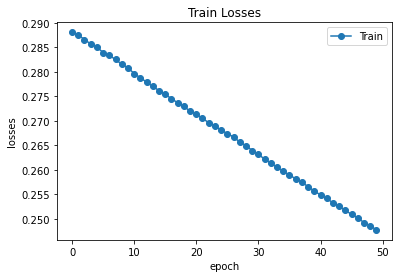

In [16]:
plt.plot(train_loss,'-o')
# plt.plot(test_loss,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train'])
plt.title('Train Losses')

plt.show()

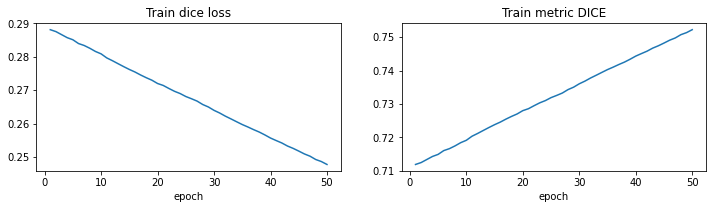

In [7]:
plt.figure("Results 25 june", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch\n")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch\n")
plt.plot(x, y)



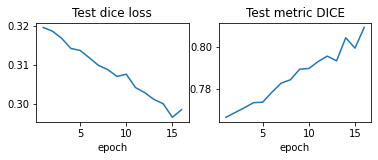

In [8]:
plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

In [9]:
path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSegmentation", "*.nii.gz")))

path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSegmentation", "*.nii.gz")))

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]
test_files = test_files[0:9]

In [10]:
test_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True), 
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),   
        ToTensord(keys=["vol", "seg"]),
    ]
)

In [11]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

In [12]:
device = torch.device('cpu')
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [13]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath,map_location=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

In [14]:
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)
ckp_path = "/content/drive/MyDrive/Dataset/results/results/best_metric_model.pth"
model, optimizer, start_epoch = load_ckp(ckp_path, model, optimizer)

# model.load_state_dict(torch.load(
#     os.path.join(model_dir, "Copy of best_metric_model.pth"),map_location=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [ ]:
for phase in ['valid', 'test']:  
        with torch.no_grad():
            for t_image, mask, image_paths, target_paths in dataLoaders[phase]:
            # get the inputs
                t_image, mask = t_image.to(device), mask.to(device)
            
                output = model(t_image)
                probability_class = torch.exp(output) # logit or probability for two classes
                prediction = torch.argmax(probability_class,1) # predic for each class (torch.argmax Returns the indices of the maximum values of a tensor across a dimension)
                cm = confusion_matrix(prediction.view(-1), mask.view(-1))
                #print('{} {} cm:'.format(phase, cm))
                
                # performance metrics for the model
                score_accuracy = accuracy_score(prediction.view(-1), mask.view(-1))
                report = classification_report(prediction.view(-1), mask.view(-1)) 
                
                fpr, tpr, _ = roc_curve(prediction.view(-1), mask.view(-1))
                roc_auc = auc(fpr,tpr)

            print('{} score_accuracy: {:.4f}'.format(phase, score_accuracy))  
            
            print('{} Confusion Matrix: {}'.format(phase, cm))  
            print(report)
            
            plt.figure()
            plt.imshow(cm, interpolation='None', cmap=plt.cm.Wistia)
            classNames = ['Negative','Positive']
            plt.title('Confusion Matrix')
            plt.ylabel('True class')
            plt.xlabel('Predicted class')
            tick_marks = numpy.arange(len(classNames))
            plt.xticks(tick_marks, classNames)
            plt.yticks(tick_marks, classNames)
            s = [['TN','FP'], ['FN', 'TP']]
            for i in range(2):
                for j in range(2):
                    plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))  

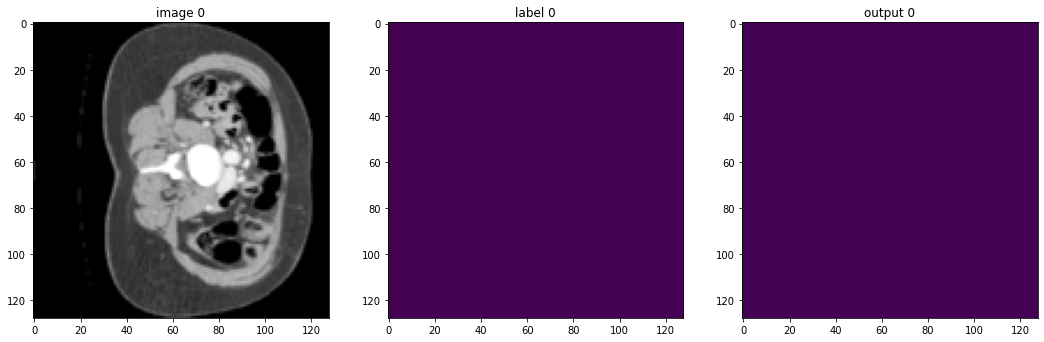

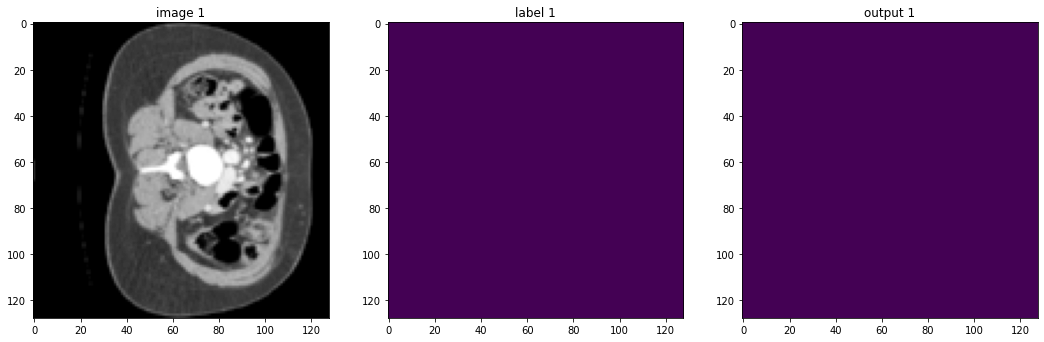

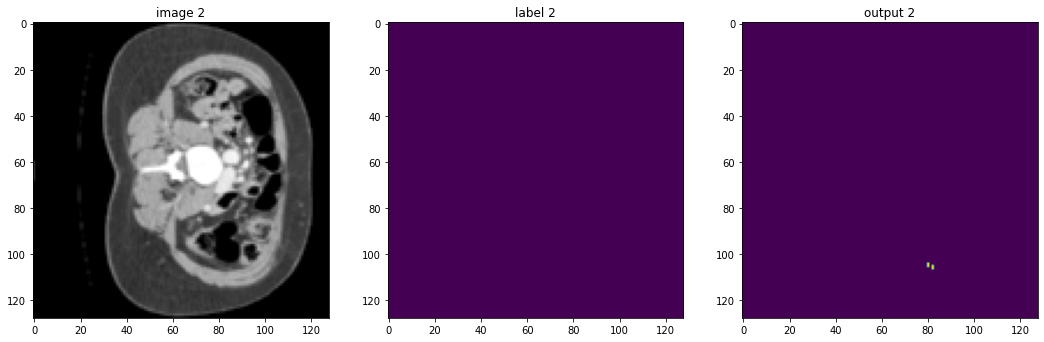

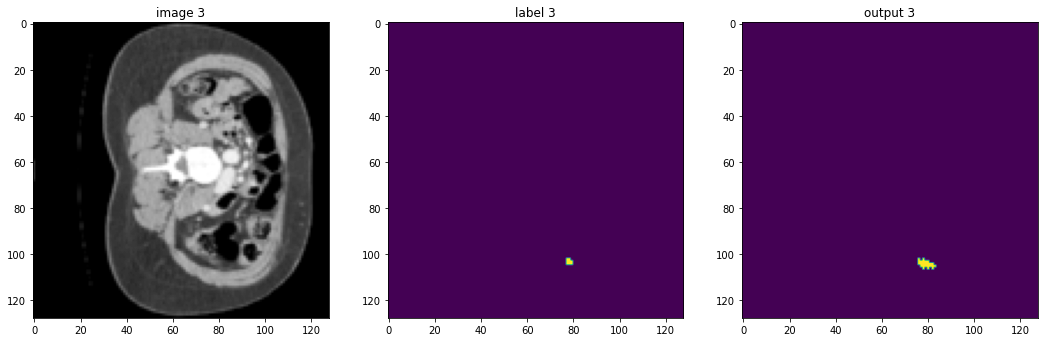

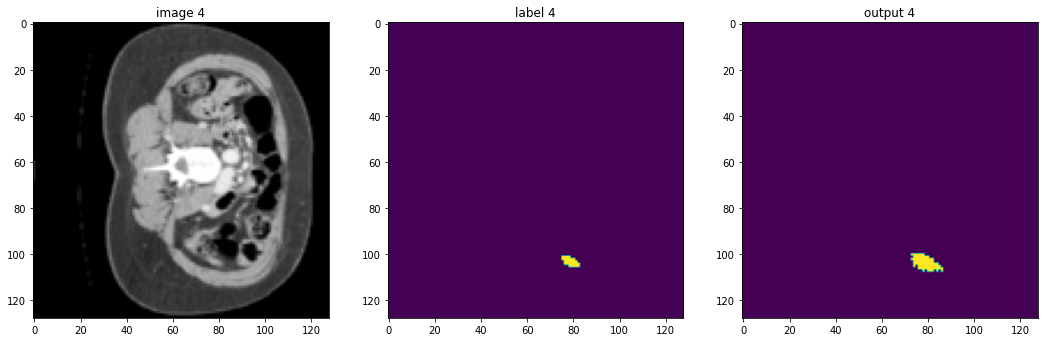

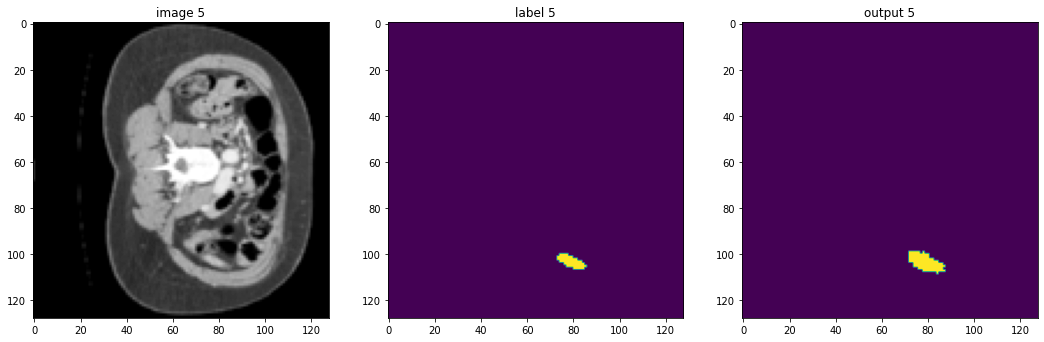

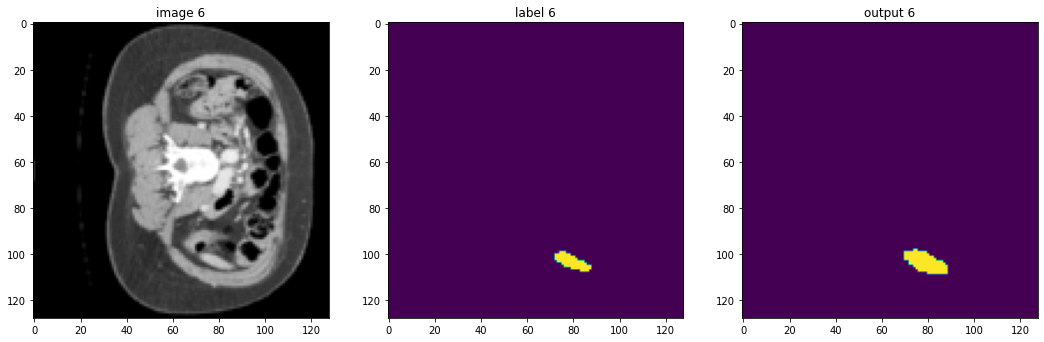

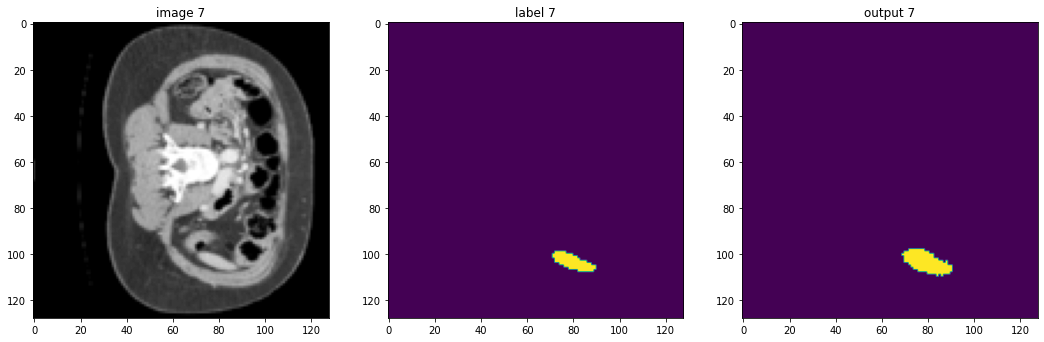

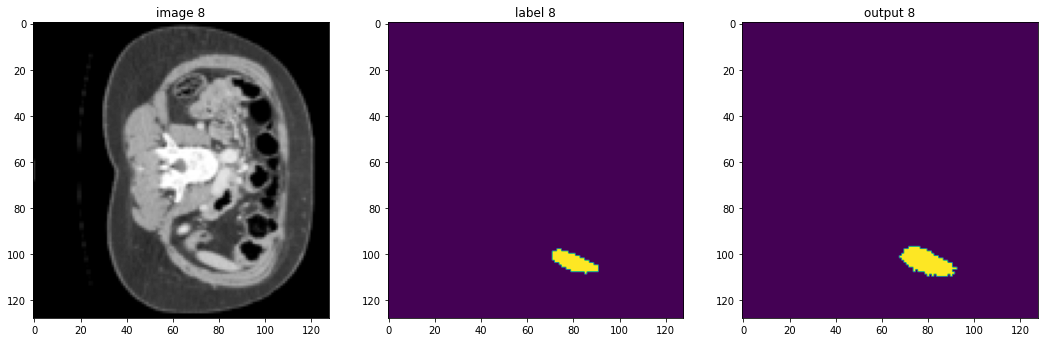

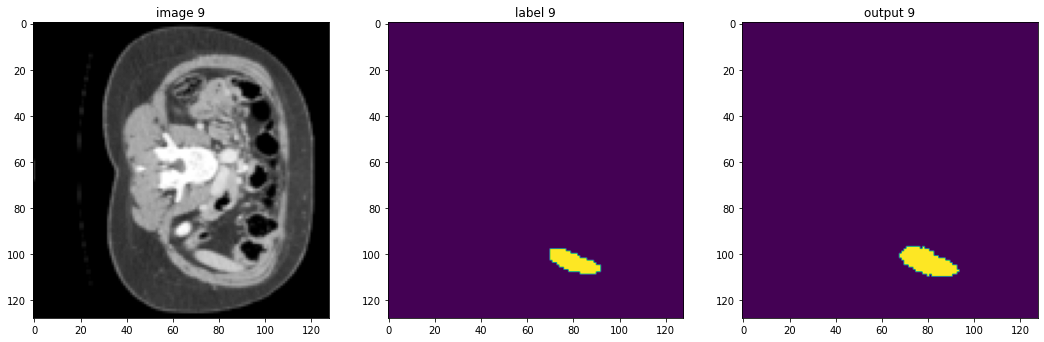

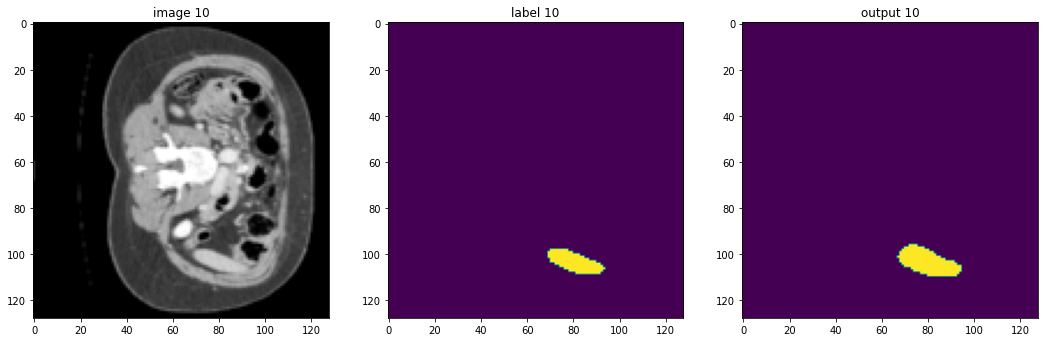

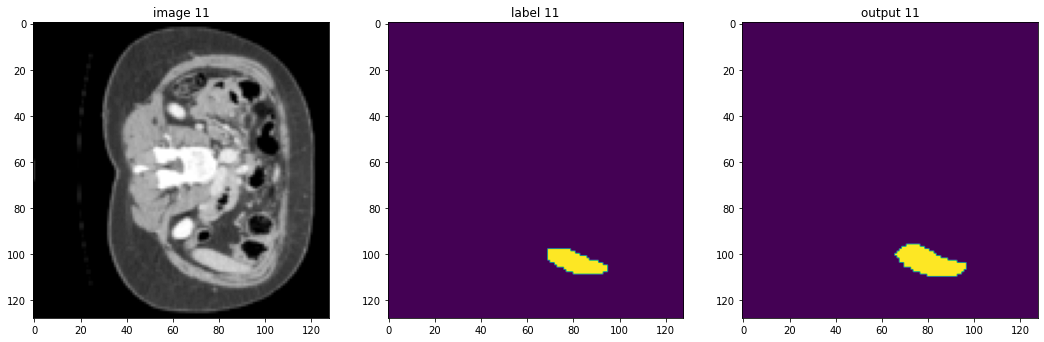

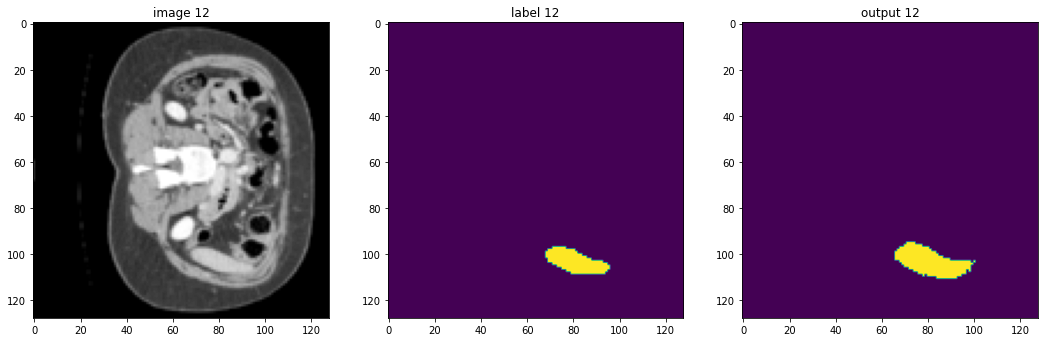

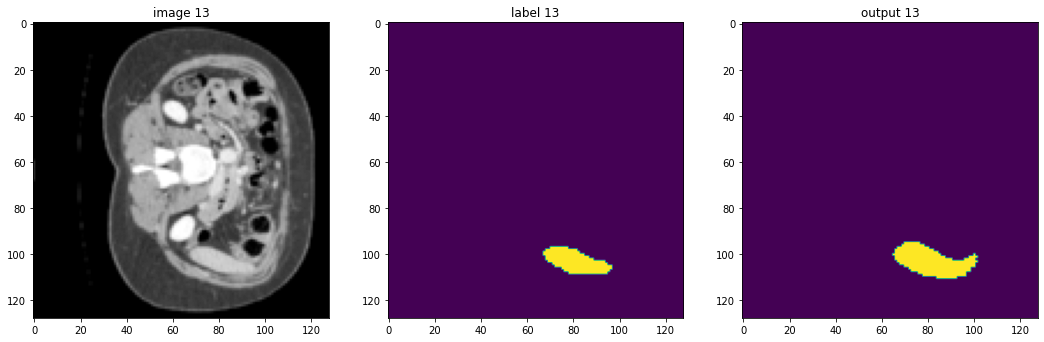

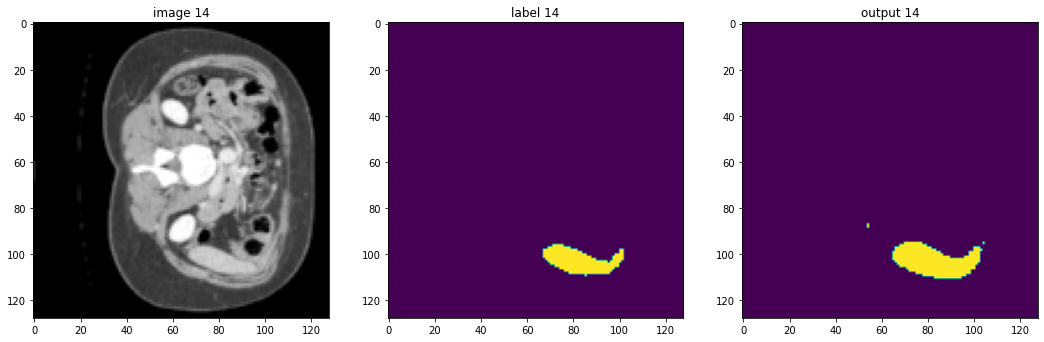

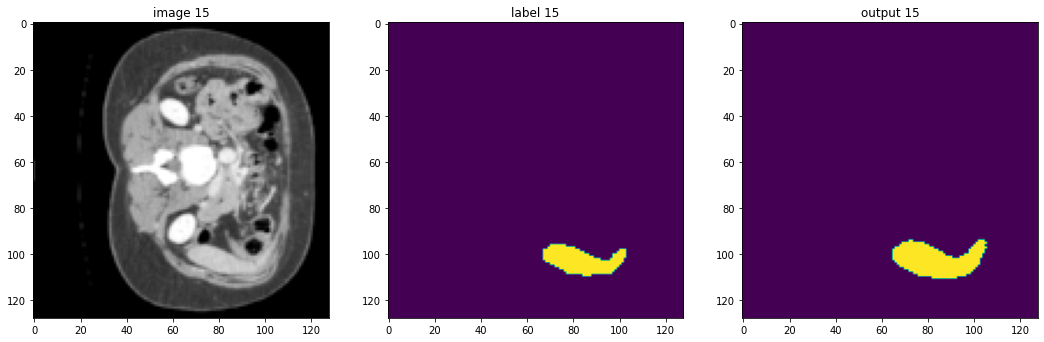

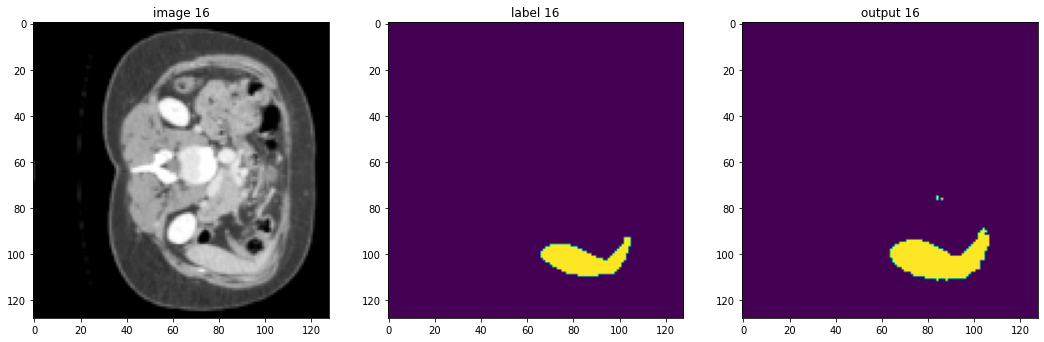

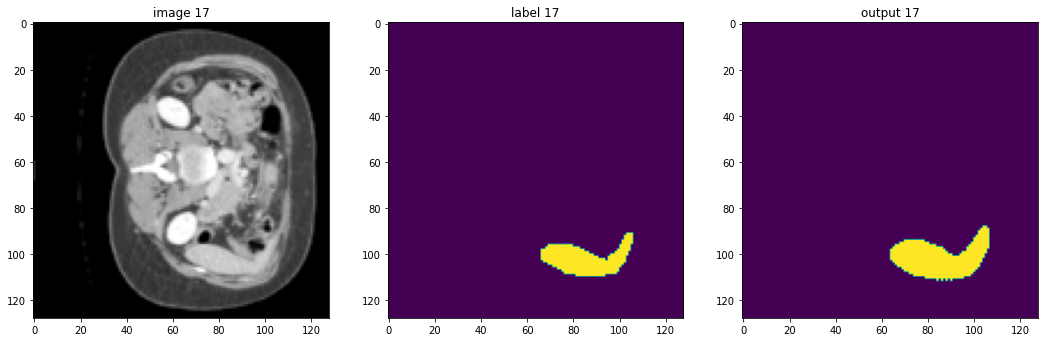

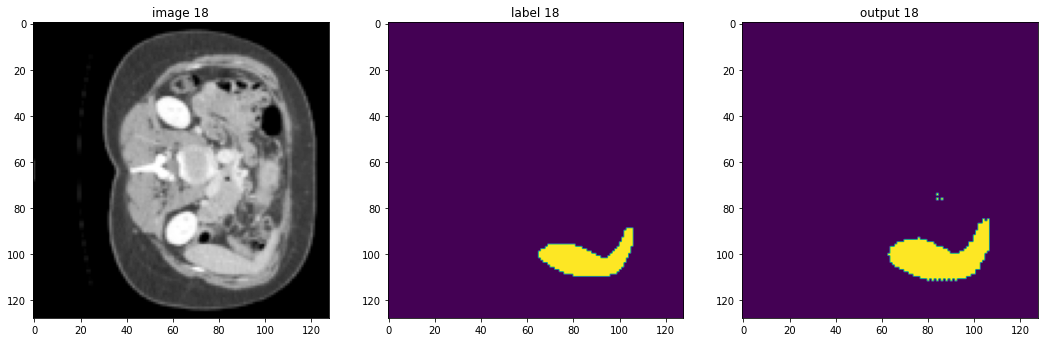

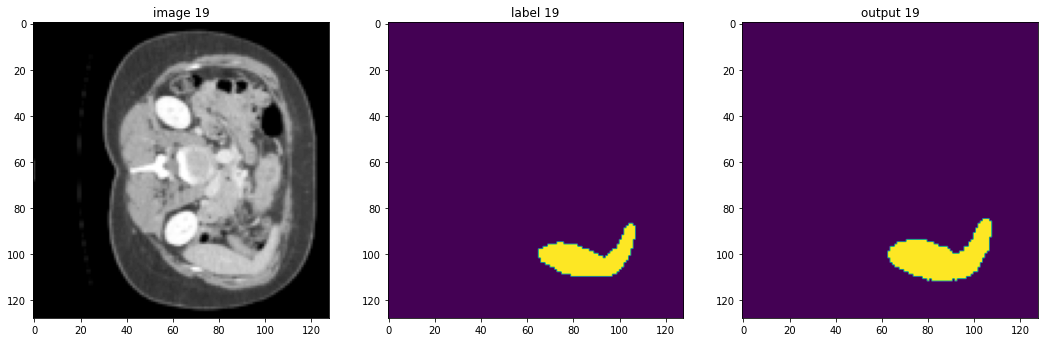

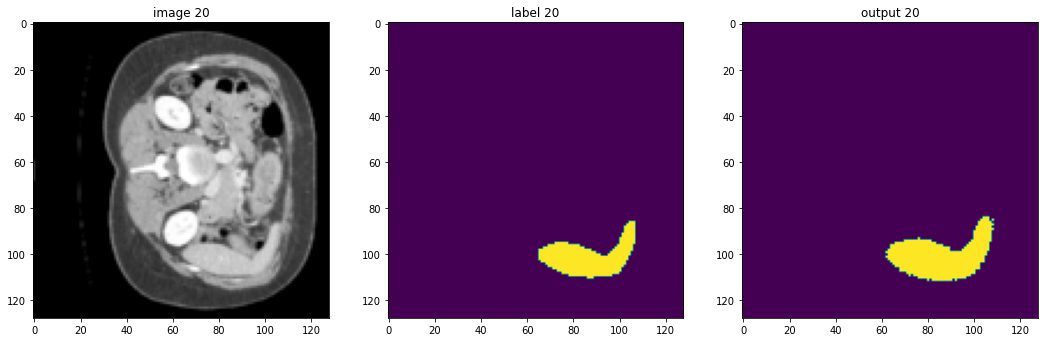

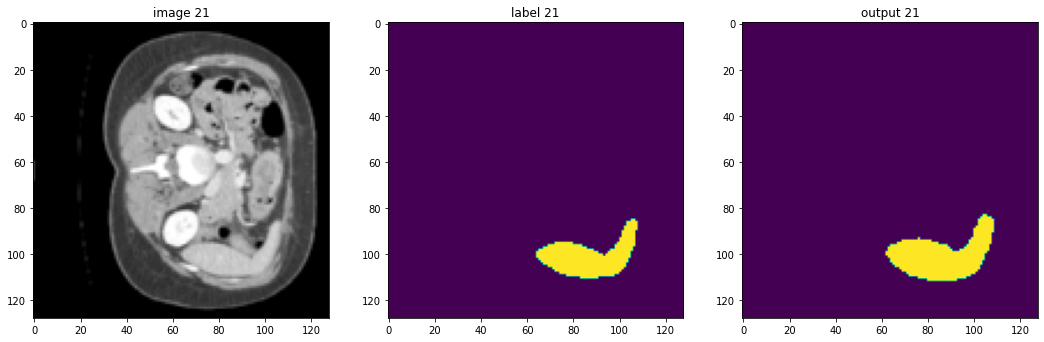

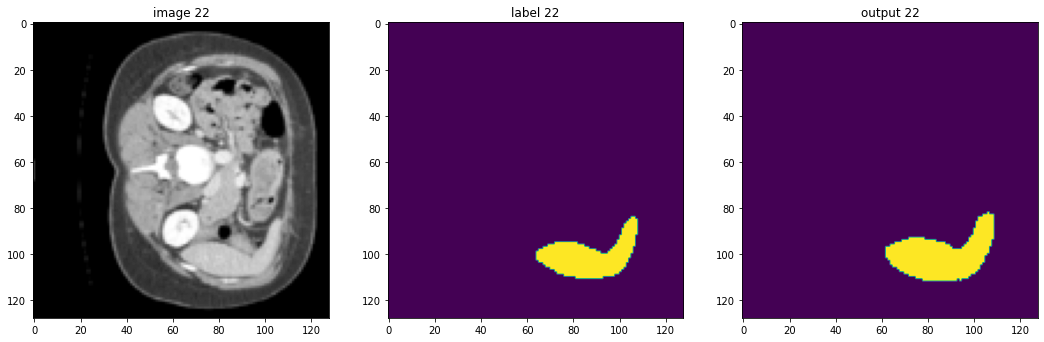

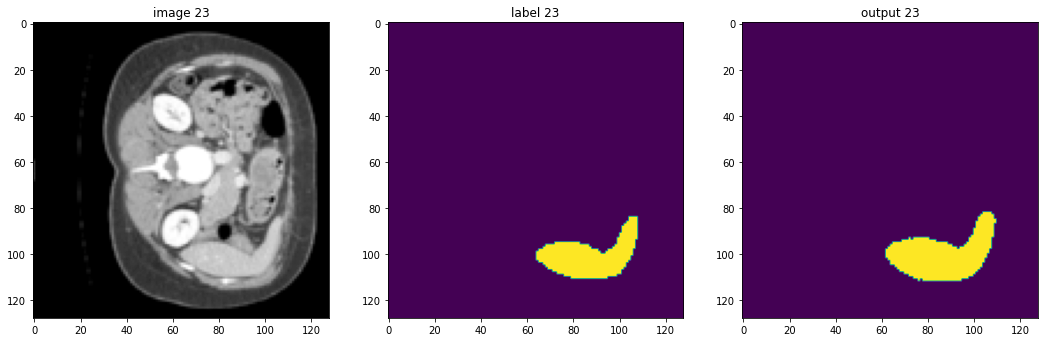

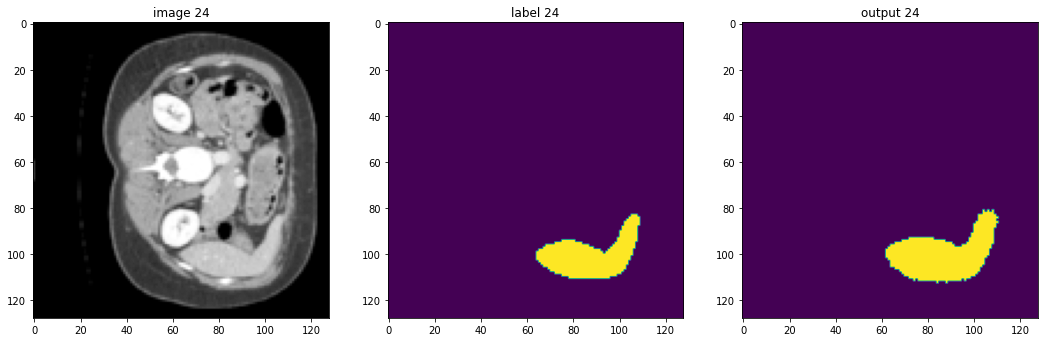

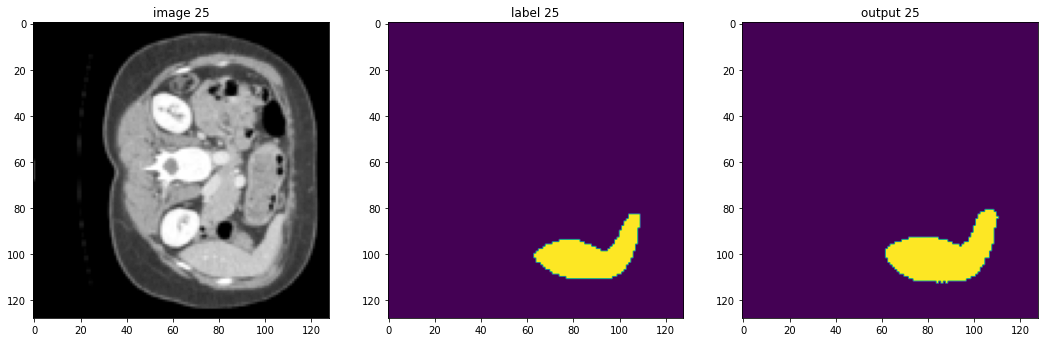

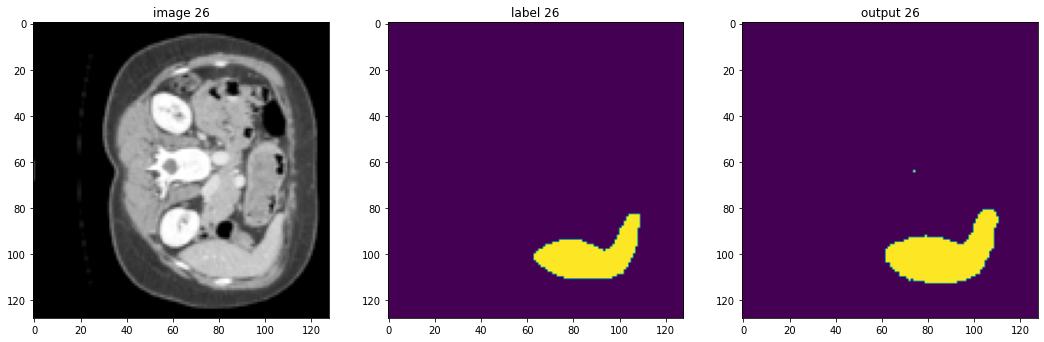

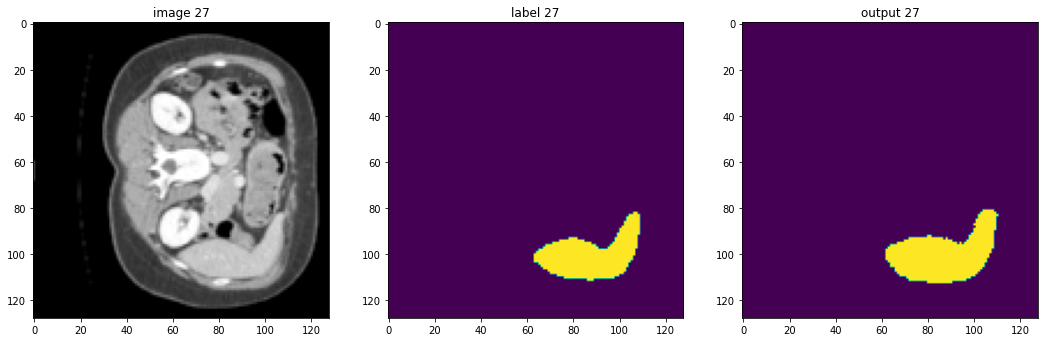

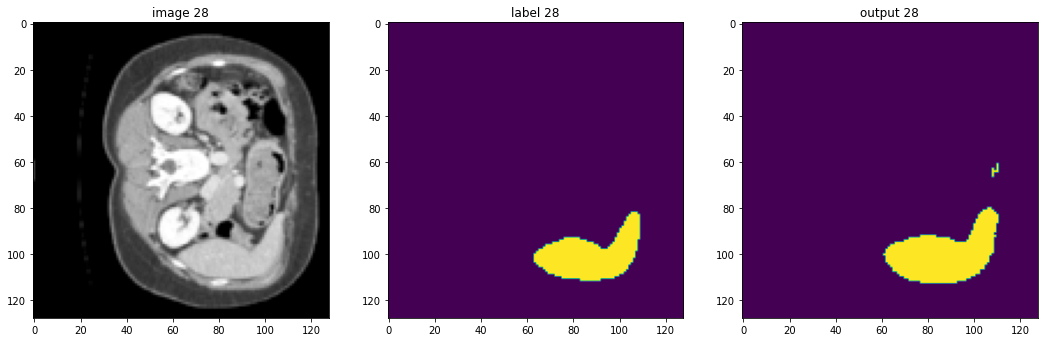

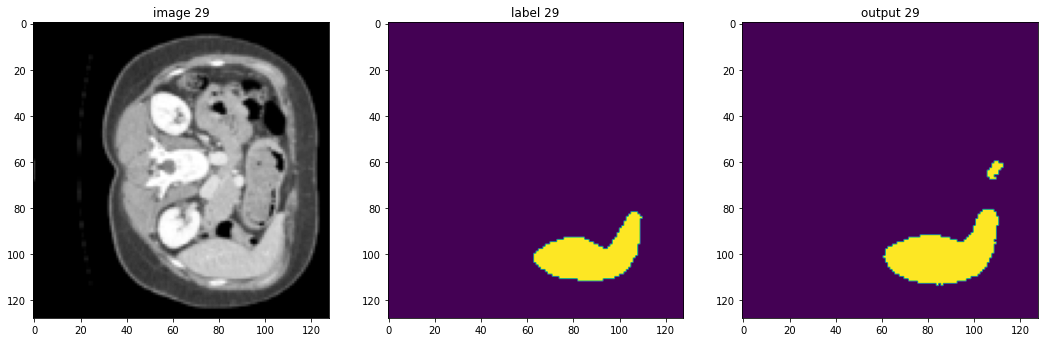

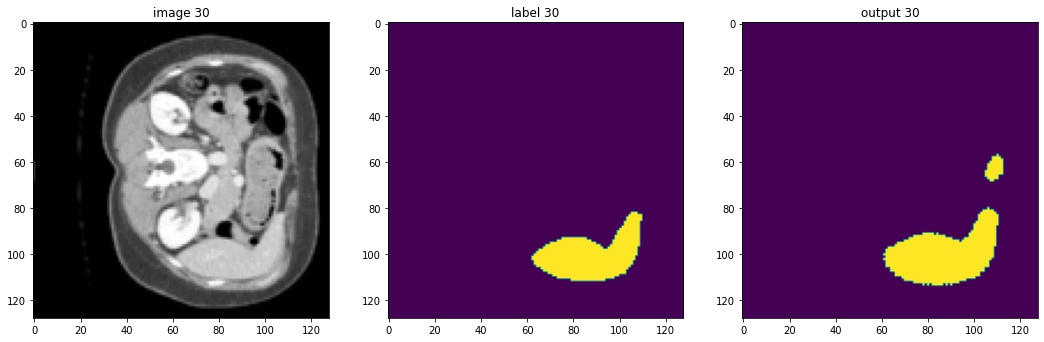

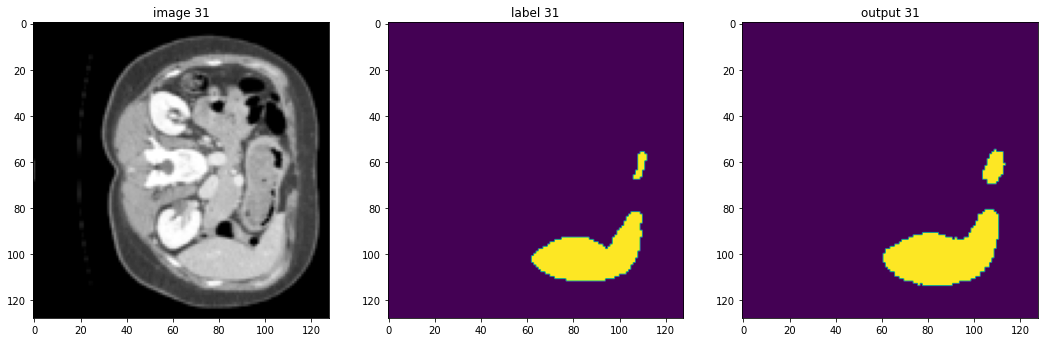

In [ ]:
sw_batch_size = 4
roi_size = (128, 128, 64)
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['vol']
    t_segmentation = test_patient['seg']
    
    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.53
        
    for i in range(32):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()